In [1]:
# Jeyan Thiyagalingam, SciML, STFC, August 1st, 2020
# A naive implementation of the plain vanilla VAE - can be optimised, improved etc. 
# If this script can be improved, please let me know - (t.jeyan@stfc.ac.uk)

# Implementation of a VAE (+NN+MNIST)

This is a an implementation of the "Auto Encoding Variational Bayes" paper [here](https://arxiv.org/abs/1312.6114).

The idea is to reconstruct the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) using VAE. A simple neural network is used as encoder and decoder than anything complicated.  

## What are VAEs

Autoencoders are a type of neural network that can be used to learn efficient codings of input data. Given some inputs, the network first applies a series of transformations that map the input data into a lower dimensional space. This part of the network is called the ***encoder***, and implements the posterior $q_\theta(z|x)$.

Then, the network uses the encoded data to try and recreate the inputs. This part of the network is the ***decoder***, denoted by another pdf $q_\phi(x | z)$. Using the encoder, one can compress the data of the type that is understood by the network. However, autoencoders are rarely used for this purpose, as usually there exist hand-crafted algorithms (like jpg-compression) that are more efficient.

VAE is an extention of AEs, with applications including, 
- in painting
- denoising 
- generating artificial faces, scenes etc. 

<BR>

## Basics

### Derivation of ELBO

Posterior Probability $p(z|x)$, which can be expressed as:

\begin{eqnarray}
p(z|x)&=&\frac{p(x|z)p(z)}{p(x)}\nonumber\\
&=& \frac{p(x|z)p(z)}{\int p(x|z)p(z)}
\end{eqnarray}

where $\int p(x|z)p(z)$, which is the marginal, can be intractable and cannot be computed directly. One way  to compute the overall solution $p(z|x)$ is using Monte Carlo methods (such as sampling). The method used in this notebook (and the underlying VAE paper) is  ***variational inference***. 

The idea is to identify another proxy distribution $q(z|x)$ that reasonably approximates $p(z|x)=p(x|z)p(z)$. i.e. if the KL-divergence between two pdfs, $q(x)$ and $p(z|x)$ is denoted by

$$\mathrm{KL}(q(x)||p(z|x))$$


it can be minimized by selecting an alternative pdf $q(z|x)$, which is a good proxy for $p(z|x)$. But 

\begin{eqnarray}
\mathrm{KL}(q(z|x)||p(z|x)) &=& -\int q(z|x)\log\frac{p(z|x)}{q(z|x)} dz\nonumber\\
                          &=& -\int q(z|x)\log\frac{p(x|z)p(z)}{p(x)q(z|x)} dz\nonumber\\
                          &=& -\int q(z|x)\log\frac{p(x|z)p(z)}{q(z|x)}dz + \int_{z} q(z|x)\log p(x)dz \nonumber\\
                          &=& -\int q(z|x)\log\frac{p(x|z)p(z)}{q(z|x)} +  \log p(x)\int_{z} q(z|x)dz\nonumber\\   
                          &=& -\int q(z|x)\log\frac{p(x|z)p(z)}{q(z|x)}dz +  \log p(x)\nonumber\\
                          &=& -\int q(z|x)\log\frac{p(z)}{q(z|x)}dz -\int q(z|x)\log{p(x|z)}dz + \log p(x) 
\end{eqnarray}


Given that $\mathrm{KL}\left(q(z|x)||p(z|x)\right)\geq 0$, 




\begin{eqnarray}
-\int q(z|x)\log\frac{p(z)}{q(z|x)}dz -\int q(z|x)\log{p(x|z)}dz + \log p(x) &\geq& 0 \\
\log p(x) &\geq& \int q(z|x)\log\frac{p(z)}{q(z|x)}dz + \int q(z|x)\log{p(x|z)}dz\\
\log p(x) &\geq& - \mathrm{KL}(q(z|x)||p(z)) + \int q(z|x)\log p(x|z)dz \nonumber\\
\log p(x) &\geq& - \mathrm{KL}(q(z|x)||p(z)) + \mathbb{E}_{q(z|x)}\left[\log p(x|z)\right] \nonumber\\
\end{eqnarray}

This is the *variational lower-bound*, or the evidence of lower bound (ELBO).  This remains as the objective function for the VAE. However, frameworks like TensorFlow or PyTorch need a loss function to be minimized. Maximising the log likelihood of the model evidence $p(x)$ is same as minimizing the $-\log p(x)$. The first term of the ELBO, namely,  $\mathrm{KL}(q(z|x)||p(z))$ is the *regularising* term and constrains the posterior distribution. The second term of the ELBO models the reconstruction loss. 

Now, this leaves fair bit of freedom on the choice of the prior $p(z)$. Let's assume:


$$
p(z)={\cal N}(\mu_p, \sigma_p^2)
$$

and 

$$
q(z|x)={\cal N}(\mu_q, \sigma_q^2)
$$

Thus, 

$$
p(z)=\frac{1}{\sqrt{2\pi\sigma_p^2}}\exp\left(\frac{(x-\mu_p)^2}{2\sigma_p^2}\right)
$$

and 

$$
q(z|x)=\frac{1}{\sqrt{2\pi\sigma_q^2}}\exp\left(\frac{(x-\mu_q)^2}{2\sigma_q^2}\right)
$$

The direct derivation of $\mathrm{KL}(q(z|x)||p(z))$ will give (with some simplifications)


$$
-\mathrm{KL}(q(z|x)||p(z)) = \log\frac{\sigma_q}{\sigma_p} - \frac{\left(\log\sigma_q^2-(\mu_p-\mu_q)^2\right)}{2\sigma_p^2} +\frac{1}{2} 
$$

By fixing the prior distribution $p(z)={\cal N}(0,1^2)$, 

$$
-\mathrm{KL}(q(z|x)||p(z)) = \frac{1}{2}\left[ 1 + \log\sigma_q^2 - \sigma_q^2 -\mu_q^2\right]
$$

Hence, the new ELBO is


$$
\frac{1}{2}\left[ 1 + \log\sigma_q^2 - \sigma_q^2 -\mu_q^2\right] + \mathbb{E}_{q(z|x)}\left[\log p(x|z)\right] 
$$


Let $J, B$ and $\cal{L}$ be the dimension of the latent space, and the batch size over which the sampling is done. The loss function we need to minimise (from the point of  implementation) is

$$
{\cal L} = - \sum_{j=1}^J \frac{1}{2}\Bigl[ 1 + \log\sigma_j^2 - \sigma_j^2 -\mu_j^2\Bigr] - \frac{1}{B}\sum_{l}\mathbb{E}_{q(z|x_i)}\left[\log p(x_i|z^{(i,l)})\right] 
$$



This can be observed in the code implementation below (see function implementation ``loss_function`` below)

### Reparameterisation

A valid reparameterization would be 

$$
z = \mu+\sigma\epsilon
$$


where $\epsilon$ is an auxiliary noise variable $\epsilon\sim{\cal{N}}(0, 1)$, which actually enables the reparameterization technique. Although it is possible to use $\sigma$ or more specifically $\sigma^2$, working on log scales improves the stability. i.e. 

\begin{eqnarray}
p &=& \log(\sigma^2)\\
&=& 2 * \log(\sigma)
\end{eqnarray}

To get the log standard deviation, $\log(\sigma)$, 
\begin{eqnarray}
\log(\sigma) &=& 0.5 p \\
\label{eqn:log_sigma}
\end{eqnarray} 

and hence

$$
\sigma = \exp^{0.5p}
$$

The resulting estimator (or the loss function) becomes (see Page 5 of [Auto-Encoding Variational Bayes Paper](https://arxiv.org/abs/1312.6114)),

$$
-KLD = \frac{1}{2}\sum_{j=1}^{J}(1+\log(\sigma_j^i)^2 - (\mu_j^i)^2 -(\sigma_j^i)^2)
$$


It is important to see that the KL divergence can be computed and differentiated without estimation. This is a very remarkable thing (no esimtation!).

The $\boldsymbol{\epsilon}$ must be sampled from a zero-mean, unit-variance Gaussian distribution, and should be of the same size as $\boldsymbol{\sigma}$. This is easily done using PyTorch's **``randn_like``** function. The PyTorch document states that 

> ``torch.randn_like(input)`` is equivalent to ``torch.randn(input.size(), dtype=input.dtype, layout=input.layout, device=input.device)``.


<br>


# References

1. Variational Bayes [Paper](https://arxiv.org/pdf/1312.6114.pdf)

---

# Implementation 

The implementation below has the following:

1. A loss function from the paper
1. A class implementation for VAE
1. An instance of the VAE
1. Training of the VAE
1. Testing of the VAE
1. Visualization of the latent space (uses tSNE)
1. Visualization of the posteriors
1. Implementation of two types of generative process to show the limitations of vanilla VAE.


Again, the implementation here is not optimized nor optimal. For example, there are repeated computations on the latent space, which can easily be avoided by caching some results from training etc. 
<BR>


In [2]:
# prerequisites
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import timeit
import numpy as np
from scipy import stats
import warnings

In [3]:
# Set the current device for execution using PyTorch's 'device' method
device=torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

In [4]:
# Set the parameters of the models
# Set some initial values. Changing batch size and epochs has a knock 
# on effect on the overall performance. 
BATCH_SIZE  = 128
EPOCHS=10
VERBOSE = True
LEARNING_RATE = 1e-3
USE_MULTIPLE_GPUS = False

# network architecture
# size of latent space
Z_DIM = 20
# size of hidden layer in encoder and decoder
HIDDEN_DIM = 400

In [5]:
def tic():
    t0 = timeit.default_timer()
    return t0

def toc(t0):
    t1 = timeit.default_timer() - t0
    return t1

In [6]:
# See the description above. 
# The loss function has two parts: KLD, and the conventional loss function (such as binary cross entropy).

def loss_function(recon_x, x, mu, logvar):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

## The VAE Class

This class inherits the **``nn.Module``** from **``torch.nn``**. As such, this has to implement the **``forward``** component (and the backward is automatically obtained by autodiff inside **``nn.Module``**.  The class also implements the following:

1. Encoder
1. Decoder; and
1. Reparameterisation.

### Encoder and Decoder

The exact architecture is independent of the Variational Bayes paper, and may vary with the problem.  Here, the architecture is such that:

- An encoder based on NN with Gaussian outputs - vector of means, and vector of standard deviations (or variances)
- Means are constrained between $[0,1]$ using sigmoid
- The MNIST has $28\times 28$ images with one colour channel - so the encoder/decoder inputs/outputs reflect this.


However, the encoder can include a CNN instead of a simple neural net, and can use regularisers, dropout etc.




In [7]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, HIDDEN_DIM)
        self.fc21 = nn.Linear(HIDDEN_DIM, Z_DIM)
        self.fc22 = nn.Linear(HIDDEN_DIM, Z_DIM)
        self.fc3 = nn.Linear(Z_DIM, HIDDEN_DIM)
        self.fc4 = nn.Linear(HIDDEN_DIM, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## Model training and execution - PyTorch specifics

It is worth noting the following on the **training** end 


* In PyTorch, calling ``model.train()`` or ``model.eval()``  sets the mode of execution. Possible modes of execution are:  training and evaluation. However, they **do not** inovoke the training or evaluation. 
* Calling the ``model(data)`` method invokes the forward pass on the VAE.
* Calling the ``optimizer.zero_grad()`` method resets all gradients to zero.
* A call to the ``loss.backward()`` method performs the back propagation (which uses autograd).
* A call to the ``data.to(device)`` method moves the data (which we got from the train_loader) to GPU.
* <font color='red'>There is a bug when running this across multiple GPUs. Need to debug this. At least it is slower (perhaps MNIST is not big enough). I  haven't done much profiling here. </font> 

In [8]:
def print_train_stats(batch_idx, epoch, data, train_loader, loss):
    if VERBOSE == True and batch_idx % 10 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 
                                                                       100. * batch_idx / len(train_loader), loss.item() / len(data)))

def print_train_epoch_stats(epoch, train_loss):
    if VERBOSE == True:
        print('====> Epoch: {} Average Training loss: {:.4f}'.format(epoch, train_loss))
    
    
    
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        print_train_stats(batch_idx, epoch, data, train_loader, loss)
        
    train_loss = train_loss / len(train_loader.dataset)    
    print_train_epoch_stats(epoch, train_loss)
    return train_loss 

## Model Testing 

Note the ``torch.no_grad()`` - which turns off the back propagation (which is not needed in the validation phase). Disabling gradient calculation is useful for inference when it is certain that Tensor.backward() will not be called. It will reduce memory consumption for computations. 



In [9]:
def print_test_epoch_stats(epoch, test_loss):
    if VERBOSE == True:
        print('====> Epoch: {} Test set loss: {:.4f}'.format(epoch, test_loss))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
    test_loss /= len(test_loader.dataset)
    print_test_epoch_stats(epoch, test_loss)
    return test_loss

## Getting the datasets 

Although datasets can be loaded in their own, ideally, we may want to specify the transformations to be performed on those datasets while loading them.  See [this](https://pytorch.org/docs/stable/torchvision/datasets.html) link for more details. The actual data loading is performed by the **``DataLoader``** class. The data loader has many capabilities, including chunking/partitioning the data as needed. For example, DataLoader  can load multiple samples in parallel using torch.multiprocessing workers.

The following are the key parameters 

1. root (string) – Root directory of dataset where training and testings dataset exists. 
1. train (bool, optional) – If True, creates dataset from training side  otherwise from test side. 
1. download (bool, optional) – If true, downloads the dataset from the internet and puts it in root directory. If dataset is already downloaded, it is not downloaded again.
1. transform (callable, optional) – A function/transform that takes in an PIL image and returns a transformed version. E.g, transforms.RandomCrop
1. target_transform (callable, optional) – A function/transform that takes in the target and transforms it.


<BR> 

In [10]:
# Get hold of the MNIST dataset
# Also note that the ToTensor call in PyTorch automatically converts all images into [0,1]. 
train_dataset = datasets.MNIST(root='./data/mnist/', train=True, transform=transforms.ToTensor(),  download=True)
test_dataset = datasets.MNIST(root='./data/mnist/', train=False, transform=transforms.ToTensor(), download=True)

In [11]:
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Creating an instance of the VAE class

Create the model (which is a VAE here), and move that to the GPU. This is needed before constructing the optimizer object. Check the Pytorch manual [here](https://pytorch.org/docs/stable/optim.html). Then check the learning rate to $\lambda = 10^{-3}$. 
    
The model is created and moved to the preferred device. The data is moved to the devide during the training  / testing phase. The testing phase, does not use optimiser or the back-propagation.     

### Running Train / Test  per  epoch

It is worth noting that epoch is a one full cycle through the training data. Usually, the model is validated after each training epoch to get a signal about the model’s ability to generalize, i.e. how high the validation accuracy is (or how low the validation loss gets). Using these validation techniques like early stopping can be applied in order to stop the training once  the model starts to overfit. Running the validation (or test) for several epochs sequentially doesn’t make sense, as the metrics won’t change. 
    
Inside the epoch loop, decoding on a random sample is performed just to see a visualization of the generated image from a random sample. Please note, the test(epoch) function gives the quantitative value which tells  how well the model performs. However, the image generation is intended for qualitative comparison, i.e., how the model improves image generation with each epoch. This can be skipped without any issues. 
    

In [12]:
model = VAE().to(device)
if USE_MULTIPLE_GPUS == True and torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    print("Using DataParallel Model")
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
train_losses, test_losses = [], []
t0=tic()
for epoch in range(1, EPOCHS + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
tlapsed = toc(t0)

Train Epoch: 1 [0/60000 (0%)]	Loss: 548.781982
Train Epoch: 1 [1280/60000 (2%)]	Loss: 293.183868
Train Epoch: 1 [2560/60000 (4%)]	Loss: 227.399048
Train Epoch: 1 [3840/60000 (6%)]	Loss: 224.212860
Train Epoch: 1 [5120/60000 (9%)]	Loss: 222.822754
Train Epoch: 1 [6400/60000 (11%)]	Loss: 207.343994
Train Epoch: 1 [7680/60000 (13%)]	Loss: 207.026215
Train Epoch: 1 [8960/60000 (15%)]	Loss: 204.344986
Train Epoch: 1 [10240/60000 (17%)]	Loss: 194.677643
Train Epoch: 1 [11520/60000 (19%)]	Loss: 177.487686
Train Epoch: 1 [12800/60000 (21%)]	Loss: 181.882401
Train Epoch: 1 [14080/60000 (23%)]	Loss: 177.296936
Train Epoch: 1 [15360/60000 (26%)]	Loss: 175.231445
Train Epoch: 1 [16640/60000 (28%)]	Loss: 165.120880
Train Epoch: 1 [17920/60000 (30%)]	Loss: 170.290482
Train Epoch: 1 [19200/60000 (32%)]	Loss: 163.058823
Train Epoch: 1 [20480/60000 (34%)]	Loss: 162.032959
Train Epoch: 1 [21760/60000 (36%)]	Loss: 158.155304
Train Epoch: 1 [23040/60000 (38%)]	Loss: 153.374390
Train Epoch: 1 [24320/60000 

Train Epoch: 4 [17920/60000 (30%)]	Loss: 110.918259
Train Epoch: 4 [19200/60000 (32%)]	Loss: 112.493927
Train Epoch: 4 [20480/60000 (34%)]	Loss: 111.623840
Train Epoch: 4 [21760/60000 (36%)]	Loss: 109.916496
Train Epoch: 4 [23040/60000 (38%)]	Loss: 111.799255
Train Epoch: 4 [24320/60000 (41%)]	Loss: 115.292435
Train Epoch: 4 [25600/60000 (43%)]	Loss: 111.979805
Train Epoch: 4 [26880/60000 (45%)]	Loss: 112.456451
Train Epoch: 4 [28160/60000 (47%)]	Loss: 109.018936
Train Epoch: 4 [29440/60000 (49%)]	Loss: 110.302277
Train Epoch: 4 [30720/60000 (51%)]	Loss: 116.825371
Train Epoch: 4 [32000/60000 (53%)]	Loss: 111.188980
Train Epoch: 4 [33280/60000 (55%)]	Loss: 108.782547
Train Epoch: 4 [34560/60000 (58%)]	Loss: 109.918991
Train Epoch: 4 [35840/60000 (60%)]	Loss: 116.523064
Train Epoch: 4 [37120/60000 (62%)]	Loss: 110.375122
Train Epoch: 4 [38400/60000 (64%)]	Loss: 111.732880
Train Epoch: 4 [39680/60000 (66%)]	Loss: 112.959335
Train Epoch: 4 [40960/60000 (68%)]	Loss: 110.234291
Train Epoch:

Train Epoch: 7 [34560/60000 (58%)]	Loss: 110.934906
Train Epoch: 7 [35840/60000 (60%)]	Loss: 111.945786
Train Epoch: 7 [37120/60000 (62%)]	Loss: 107.629196
Train Epoch: 7 [38400/60000 (64%)]	Loss: 107.035522
Train Epoch: 7 [39680/60000 (66%)]	Loss: 111.234428
Train Epoch: 7 [40960/60000 (68%)]	Loss: 108.445602
Train Epoch: 7 [42240/60000 (70%)]	Loss: 108.359230
Train Epoch: 7 [43520/60000 (72%)]	Loss: 109.492950
Train Epoch: 7 [44800/60000 (75%)]	Loss: 109.211960
Train Epoch: 7 [46080/60000 (77%)]	Loss: 109.247612
Train Epoch: 7 [47360/60000 (79%)]	Loss: 103.539436
Train Epoch: 7 [48640/60000 (81%)]	Loss: 111.106384
Train Epoch: 7 [49920/60000 (83%)]	Loss: 108.879196
Train Epoch: 7 [51200/60000 (85%)]	Loss: 107.832382
Train Epoch: 7 [52480/60000 (87%)]	Loss: 108.850021
Train Epoch: 7 [53760/60000 (90%)]	Loss: 103.613190
Train Epoch: 7 [55040/60000 (92%)]	Loss: 107.450172
Train Epoch: 7 [56320/60000 (94%)]	Loss: 102.750488
Train Epoch: 7 [57600/60000 (96%)]	Loss: 103.711990
Train Epoch:

Train Epoch: 10 [51200/60000 (85%)]	Loss: 107.265831
Train Epoch: 10 [52480/60000 (87%)]	Loss: 104.054680
Train Epoch: 10 [53760/60000 (90%)]	Loss: 108.009178
Train Epoch: 10 [55040/60000 (92%)]	Loss: 107.379646
Train Epoch: 10 [56320/60000 (94%)]	Loss: 108.574715
Train Epoch: 10 [57600/60000 (96%)]	Loss: 106.297943
Train Epoch: 10 [58880/60000 (98%)]	Loss: 105.913757
====> Epoch: 10 Average Training loss: 106.3029
====> Epoch: 10 Test set loss: 105.7628


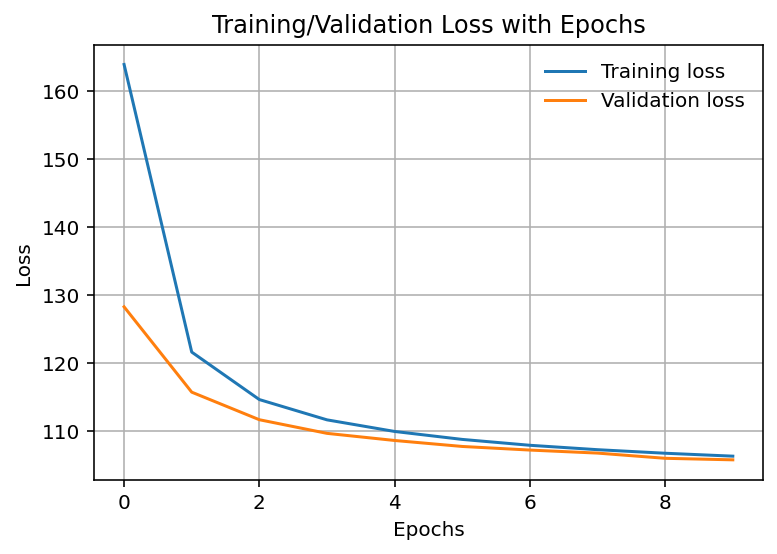

In [14]:
plt.plot(train_losses, label='Training loss');
plt.plot(test_losses, label='Validation loss');
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.title('Training/Validation Loss with Epochs')
plt.legend(frameon=False);

# Visualizing the hidden states

We only visualize the mu because mu represents corresponding latent vectors to inputs while variance is a degree of diversity of each latent vector. So latent representation of variance is not of interest to us. We will use the TSNE (sadly very slow version from scikit) for this purpose, along with matplotlib. Note that we terminate the plot lines with semicolon to avoid junk messages. 


In [15]:
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
import seaborn as sns

In [16]:
# Re-run the training data without gradient - this may not be necessary
# The original training data can be saved for this purpose. Oh well.

model.to(device)
model.eval()

# Note that the primary dimension is set to 0. 
h_mu = torch.zeros((0,Z_DIM), device=device)
h_logvar = torch.ones((0,Z_DIM), device=device)
h_labels = torch.ones(0, dtype=torch.long)

with torch.no_grad():
    for i, (data, target) in enumerate(train_loader):
        data = data.to(device)
        _, x_mu, x_logvar = model(data)
        h_mu = torch.cat( (h_mu, x_mu), 0)
        h_logvar = torch.cat((h_logvar, x_logvar), 0)
        h_labels = torch.cat( (h_labels, target))

h_mu = h_mu.cpu()
h_logvar = h_logvar.cpu()

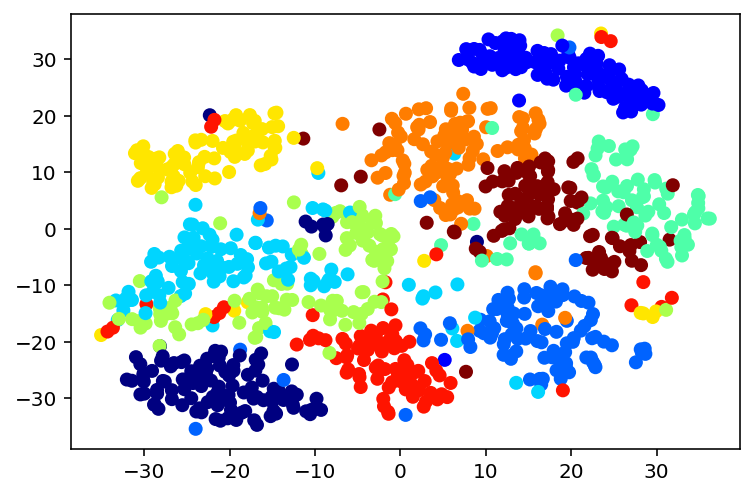

In [17]:
# plotting t-SNE is extremely expensive
# be careful about using a large PLOT_TSNE_SIZE
PLOT_TSNE = True
PLOT_TSNE_SIZE =1000
if PLOT_TSNE == True:
    tsne_mnist = TSNE(learning_rate=200, perplexity=40, 
                      n_iter=5500).fit_transform(h_mu.detach().numpy()[:PLOT_TSNE_SIZE])
    plt.scatter(tsne_mnist[:PLOT_TSNE_SIZE, 0], tsne_mnist[:PLOT_TSNE_SIZE, 1],  
                c=h_labels[:PLOT_TSNE_SIZE],  cmap = plt.cm.get_cmap("jet", 10));

# Individual Distributions 

Now, let's look at the individual conditional distributions, $p(z|y)$, where $y$ is the label, and $z$ is the latent variable. 


In [18]:
# A function for getting custom text
def getCustomTitle(pdf_x, digit_index):
    mean = "{:.2f}".format(torch.mean(pdf_x).item())
    var = "{:.2f}".format(torch.var(pdf_x).item())
    title_str = 'Distribution for Digit %i' %digit_index + '\n' 
    title_str += r'${\cal N}(\mu=$' + mean + r'$,\sigma=$' + var + r'$)$'
    return title_str 

In [19]:
# My own custom 2-in-a-row dist plotter
def customDistPlot(axes, pdf_a, pdf_b, i):
    mean_a, var_a, mean_b, var_b = torch.mean(pdf_a).item(), torch.var(pdf_a).item(), torch.mean(pdf_b).item(), torch.var(pdf_b).item()

    sns.distplot(pdf_a, color='g', ax=axes[0]);
    sns.distplot(pdf_b, color='b', ax=axes[1]);
    
    axes[0].set_title(getCustomTitle(pdf_a, i));
    axes[1].set_title(getCustomTitle(pdf_b, i+1));
    
    axes[0].axvline(mean_a, color='red');
    axes[1].axvline(mean_b, color='red');
        
    axes[0].grid(True);
    axes[1].grid(True);

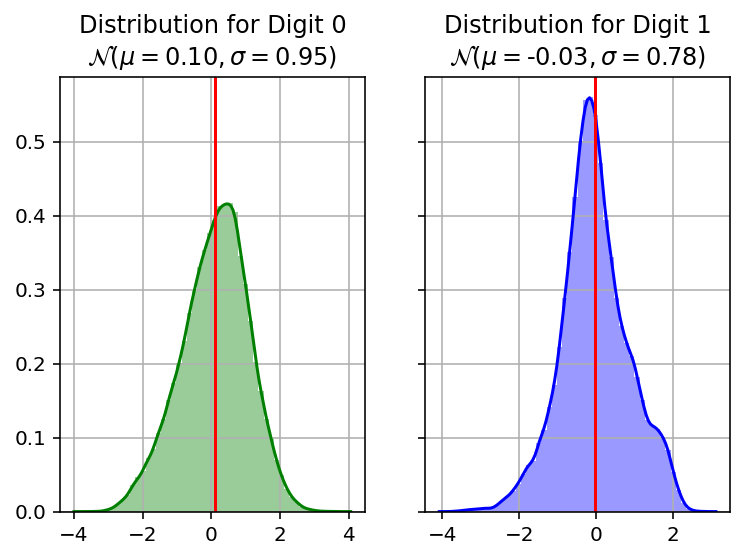

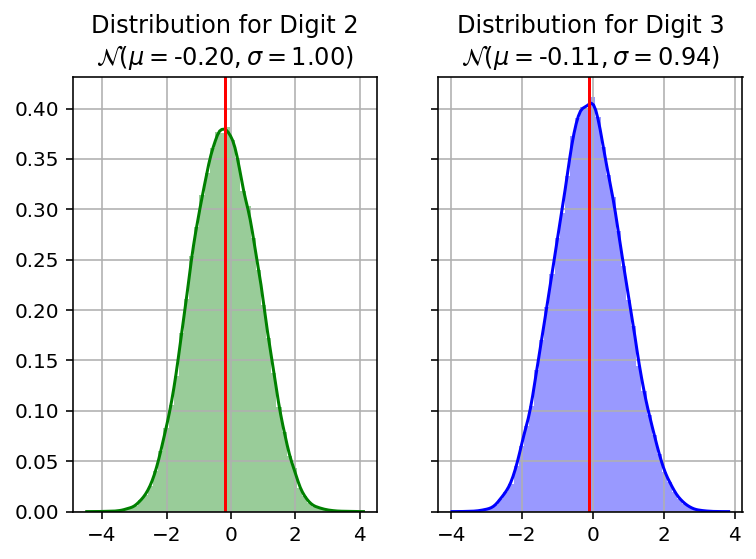

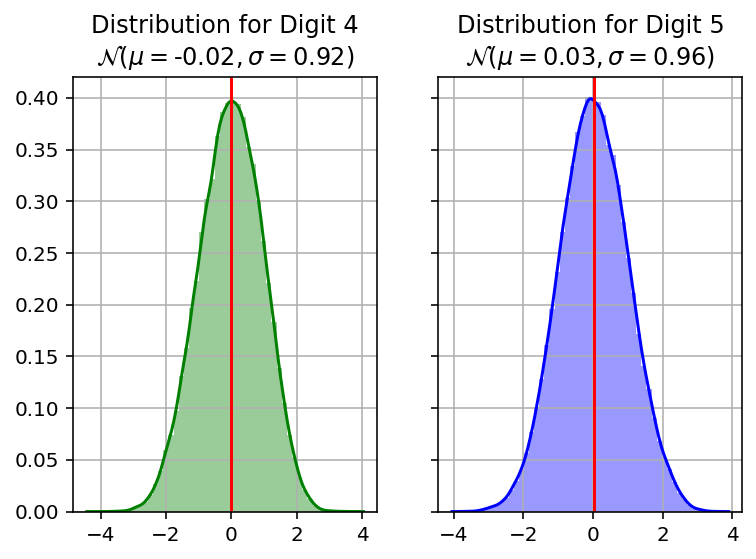

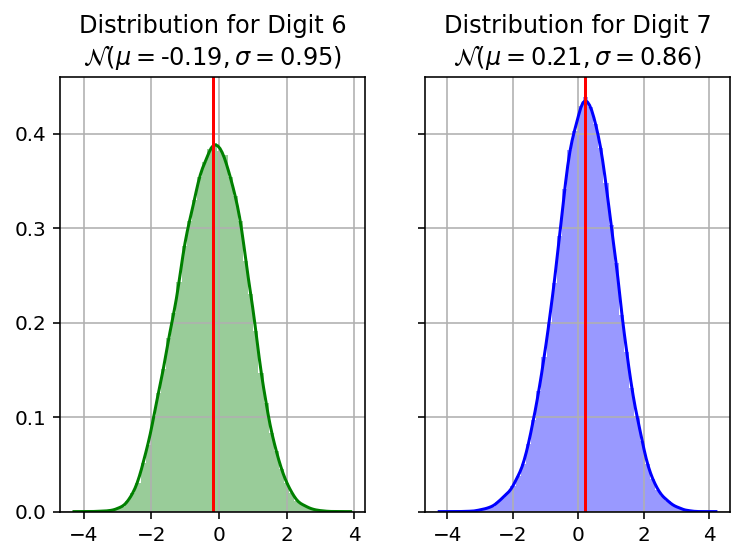

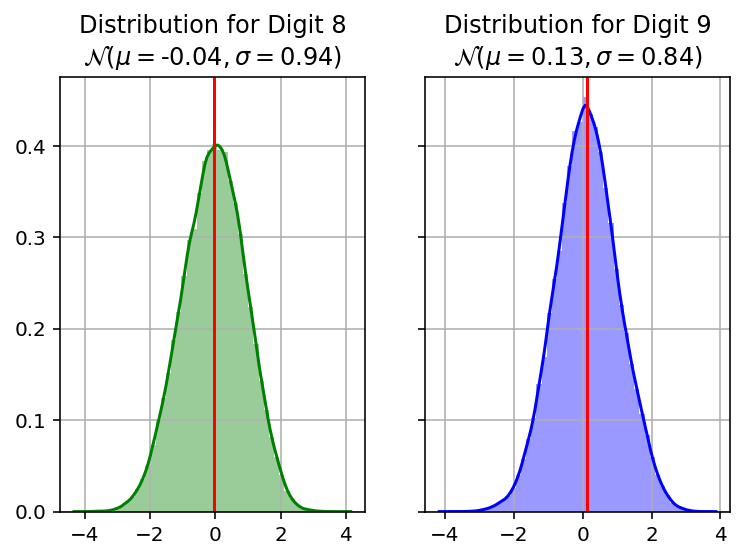

In [20]:
SEPRATE_PDF_PLOTS = True
if SEPRATE_PDF_PLOTS == True:
    for i in range(0,10,2):
        f, axes = plt.subplots(1,2,sharex=False, sharey='row');    
        pdf_a, pdf_b = h_mu[h_labels==i,:], h_mu[h_labels==i+1,:]
        customDistPlot(axes, pdf_a, pdf_b, i);

## Show all distributions together

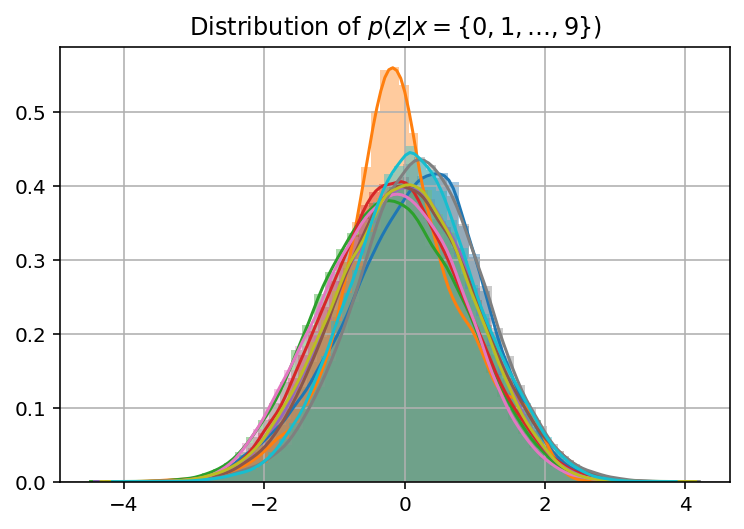

In [21]:
COMBINED_PDF_PLOT = True
if COMBINED_PDF_PLOT == True:
    plt.figure()
    for i in range(0,10):
        pdf_a = h_mu[h_labels==i,:]
        sns.distplot(pdf_a)
    plt.grid(True)
    plt.title(r'Distribution of $p(z|x=\{0,1,\ldots,9\})$');

It is worth noting that all posteriors, $p(z|x=\{0,1,\ldots,9\})$, overlap and there is almost no separation. This is likely to challenge the sampling process. 

# Data Generation

Now, we got the posterior $p(z|x)$ in place. We can try and generate some digits from these now. 

## 1. Sampling from the Normal distribution

All posteriors, are overlapping and they all appear to be a normal distribution with $\mu=0$, and $\sigma=1$. We can exploit this for the data generation. To do this, we need an internal representation $z$, matching the dimensions we specified above, $20 x 20$. Once we have the $z$, we can pass this to the decoder (without backprop), to generate $\hat{x}$. i.e. we create a latent representation $z$ by sampling a normal distribution $N(\mu=0,\sigma^2=1)$. Consult the  ``torch.distributions.Normal``. 

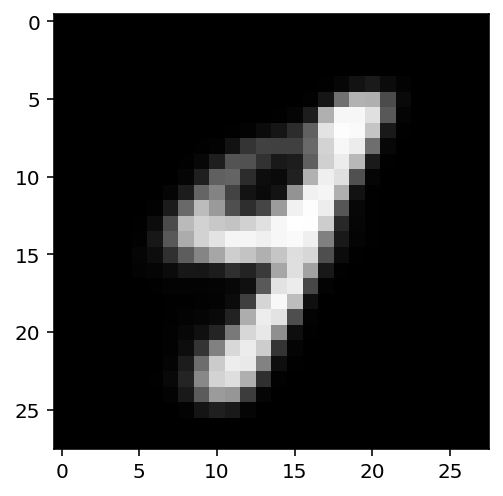

In [22]:
z = torch.distributions.Normal(torch.zeros(1,Z_DIM), torch.ones(1,Z_DIM)).sample().to(device)
with torch.no_grad():
    x_hat = model.decode(z)
x_hat = x_hat.cpu()
plt.imshow(x_hat.view(28,28), cmap='gray');

As can be seen, there is no control over what the outputs are. 

## 2. Sampling from the derived distribution

Here, we will be sampling from the individual distribution we derived above. Let's assume we would like to generate digit 7. For this, we will need the pdf, $p(z|x=7)$. 


In [23]:
# Digit to be generated
digit = 7

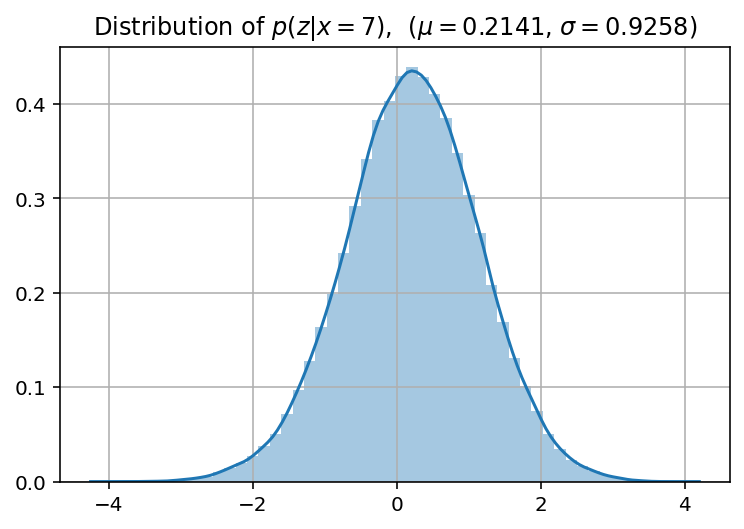

In [24]:
pdf_x_mu = h_mu[h_labels==digit,:]
sns.distplot(pdf_x_mu)
mu_x = torch.mean(pdf_x_mu)
sigma_x = torch.std(pdf_x_mu)
plt.grid(True)
plt.title(r'Distribution of $p(z|x={0})$,  ($\mu=${1:0.4f}, $\sigma=${2:.4f})'.format(digit, mu_x, sigma_x));

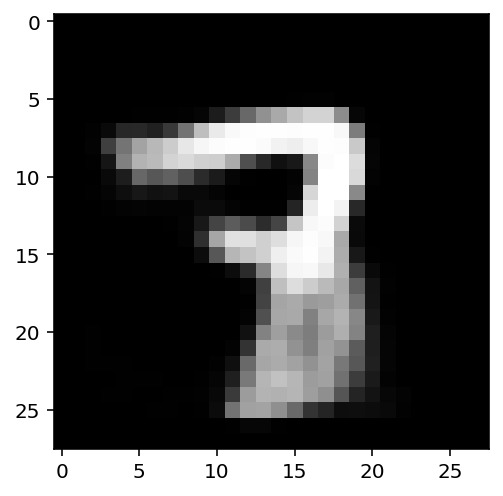

In [25]:
z_x = torch.distributions.Normal(torch.tensor([mu_x]), torch.tensor([sigma_x])).sample((1,Z_DIM))
z_x = z_x.view(1,Z_DIM).to(device)
with torch.no_grad():
    x_hat = model.decode(z_x)
x_hat = x_hat.cpu()
plt.imshow(x_hat.view(28,28), cmap='gray');

Again, there is no control over what is being generated. Surely, we made some simplifications here, but they do not contribute to this 'lack of control' over the generative process. 

## 3. Sampling from the derived distribution (Sanity Check)
Finally, we can use the hidden representation of a particular digit. This is nothig more than a look-up table, and boring (and useless). But let's do this for a sanity check. Assume we would like to generate a digit '5'. 

In [26]:
# Digit to be generated
digit = 5

In [27]:
mu_d_all = h_mu[h_labels==digit,:]
logvar_d_all = h_logvar[h_labels==digit, :]

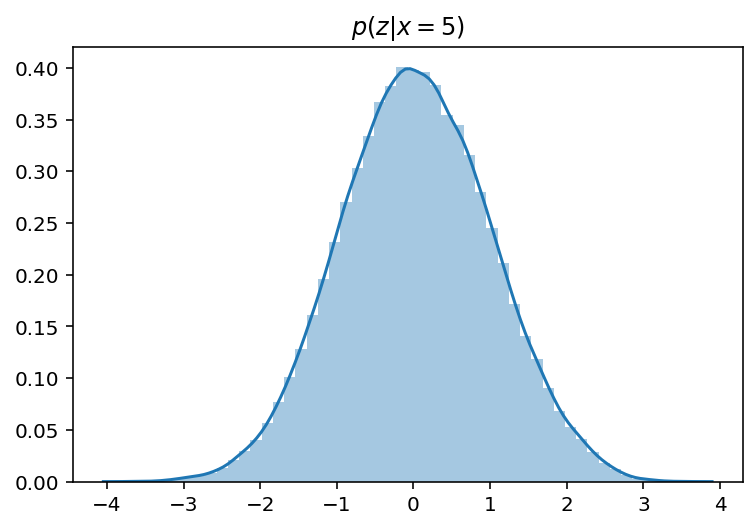

In [28]:
sns.distplot(mu_d_all)
plt.title(r'$p(z|x=${0}$)$'.format(digit));

In [29]:
# Draw a random sample (similar to finding a point )
n = torch.randint(0,  mu_d_all.size()[0], (1,))
mu_d = mu_d_all[n]
logvar_d = logvar_d_all[n]
z_d = model.reparameterize(mu_d, logvar_d)

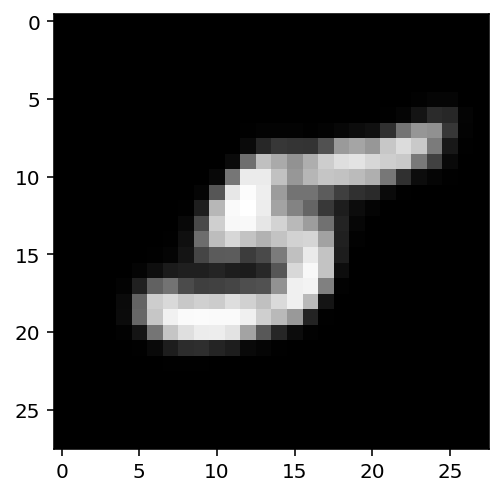

In [30]:
z_d = z_d.to(device)
with torch.no_grad():
    x_hat_d = model.decode(z_d)
x_hat_d = x_hat_d.cpu()
plt.imshow(x_hat_d.view(28,28), cmap='gray');

This shows that the decoder works, but the VAE's lack of control over the generative process. 

$\blacksquare$